## Importing libraries

In [36]:
import cv2
import numpy as np

import os
import pickle
import random

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.models import vgg16, VGG16_Weights

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

## Creating the entire dataset loading pipeline

In [2]:
def create_dataset(usage):

    breeds_dict = {}
    data = []
    
    print(f'Loading {usage}ing data... ')
    print('------------------------------------------------')
    PATH = f'/kaggle/input/dog-breeds/images/{usage}'
    breed_idx = 0
    
    breed_list = os.listdir(PATH)
    breed_list.sort()

    for breed in breed_list:
        print(f'Processing breed: {breed}... ', end='')
        breeds_dict[breed_idx] = breed
        breed_path = os.path.join(PATH, breed)
        for image in os.listdir(breed_path):
            image_path = os.path.join(breed_path, image)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            data.append([img, breed_idx])
        breed_idx += 1
        print('Done!')

    random.shuffle(data)

    X = []
    y = []

    for img, label in data:
        X.append(img)
        y.append(label)

    X = np.array(X) / 255
    y = np.array(y)
    
    print('Done!')
    print()

    return X, y, breeds_dict

In [3]:
class DogBreedsDataset(Dataset):
    def __init__(self, usage='', transform=None):
        self.X, self.y, self.breeds_dict = create_dataset(usage)
        self.transform = transform
        self.n_items = self.X.shape[0]
        
    def __len__(self):
        return self.n_items
    
    def __getitem__(self, index):
        img = self.X[index]
        label = self.y[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [5]:
training_data = DogBreedsDataset('train', transform=transform)
test_data = DogBreedsDataset('test', transform=transform)

Loading training data... 
------------------------------------------------
Processing breed: bulldog... Done!
Processing breed: german shepherd... Done!
Processing breed: golden retriever... Done!
Processing breed: labrador retriever... Done!
Processing breed: pomeranian... Done!
Processing breed: poodle... Done!
Processing breed: rottweiler... Done!
Processing breed: siberian husky... Done!
Processing breed: welsh corgi... Done!
Processing breed: yorkshire terrier... Done!
Done!

Loading testing data... 
------------------------------------------------
Processing breed: bulldog... Done!
Processing breed: german shepherd... Done!
Processing breed: golden retriever... Done!
Processing breed: labrador retriever... Done!
Processing breed: pomeranian... Done!
Processing breed: poodle... Done!
Processing breed: rottweiler... Done!
Processing breed: siberian husky... Done!
Processing breed: welsh corgi... Done!
Processing breed: yorkshire terrier... Done!
Done!



In [6]:
training_data.X.shape

(484, 200, 200, 3)

In [7]:
training_data[0][0].shape

torch.Size([3, 200, 200])

In [8]:
training_data.breeds_dict

{0: 'bulldog',
 1: 'german shepherd',
 2: 'golden retriever',
 3: 'labrador retriever',
 4: 'pomeranian',
 5: 'poodle',
 6: 'rottweiler',
 7: 'siberian husky',
 8: 'welsh corgi',
 9: 'yorkshire terrier'}

## Let's take a look at some images from the dataset

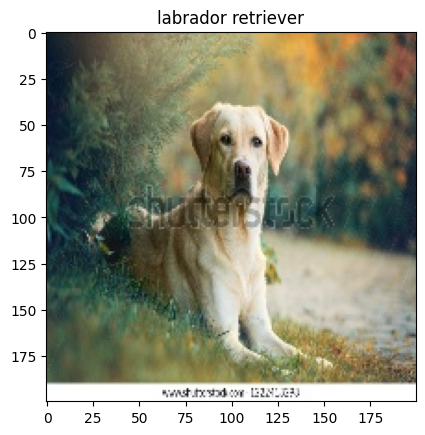

In [9]:
idx = np.random.randint(0, len(training_data))
img, label = training_data[4]
plt.imshow(img.permute(1, 2, 0))
plt.title(training_data.breeds_dict[label])
plt.show()

## Creating a dataloader for PyTorch model

In [10]:
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 200, 200])
Shape of y: torch.Size([32]) torch.int64


## Setting up the device

In [11]:
device = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using \'{device}\' device')

Using 'cuda' device


## Loading the pretrained model (which is going to be our feature extractor)

In [12]:
feature_extractor = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 155MB/s]  


In [13]:
print(feature_extractor)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Changing the model architecture for transfer learning to make the model work as a feature extractor

In [14]:
feature_extractor.avgpool = nn.Identity()
feature_extractor.classifier = nn.Identity()

print(feature_extractor)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Functions that transforms the data into features to pass to a traditional machine learning model (which performs the actual classification)

In [15]:
def extract_features_for_a_batch(model, batch):
    '''
    Extract features for a batch of images
    args:
        model: nn.Module
        batch: torch.Tensor
    returns:
        features: torch.Tensor
    '''
    features = model(batch)
    return features


def extract_all_features(model, dataloader):
    '''
    Extract features for all images in a dataloader
    args:
        model: nn.Module
        dataloader: torch.utils.data.DataLoader
    returns:
        all_features: numpy.ndarray
        labels: numpy.ndarray
    '''
    all_features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            batch_features = extract_features_for_a_batch(model, X)
            labels.append(y)
            all_features.append(batch_features)
    
    all_features = torch.cat(all_features, dim=0).cpu().numpy()
    all_features = all_features.reshape(all_features.shape[0], -1)
    
    labels = torch.cat(labels, dim=0).cpu().numpy()
    labels = labels.reshape(labels.shape[0])
    return all_features, labels

## Extracting features and labels

In [16]:
train_features, train_labels = extract_all_features(feature_extractor, train_dataloader)
test_features, test_labels = extract_all_features(feature_extractor, test_dataloader)

In [17]:
print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(484, 18432) (484,)
(188, 18432) (188,)


## Performing hyperparameter tuning to get the best machine learning model and the best parameters
We'll use `GridSearchCV` from `sklearn` to perform the tuning.

In [19]:
model1 = {
    'name': 'Random Forest',
    'model': RandomForestClassifier(random_state=42),
    'params': {
        'n_estimators': [10, 50, 100, 250],
        'max_depth': [5, 10, 20, 50]
    }
}

model2 = {
    'name': 'SVM',
    'model': SVC(random_state=42),
    'params': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly']
    }
}


estimators = [model1, model2]

In [18]:
def get_best_model(models, train_features, train_labels):
    '''
    Get the best model along with its parameters from a list of models
    args:
        models: list
        train_features: numpy.ndarray
        train_labels: numpy.ndarray
    returns:
        best_model: sklearn.model_selection.GridSearchCV
        best_params: dict
    '''
    
    best_model = None
    best_score = 0
    best_params = None
    
    for estimator in estimators:
        print(f'Fitting {estimator["name"]}... ', end='')
        clf = GridSearchCV(estimator['model'], estimator['params'], cv=5)
        clf.fit(train_features, train_labels)
        if clf.best_score_ > best_score:
            best_score = clf.best_score_
            best_model = clf.best_estimator_
            best_params = clf.best_params_
        print('Done!')
    
    print()
    print(f'Best score: {best_score}, Best model: {best_model}')
    return best_model, best_params

In [21]:
model, params = get_best_model(estimators, train_features, train_labels)

Fitting Random Forest... Done!
Fitting SVM... Done!

Best score: 0.9730884879725087, Best model: SVC(C=10, random_state=42)


## Let's take a look at the best model and its parameters

In [22]:
model

SVC(C=10, random_state=42)

In [23]:
params

{'C': 10, 'kernel': 'rbf'}

## We'll use the model we got after hyperparameter tuning to make predictions

In [24]:
model.fit(train_features, train_labels)

SVC(C=10, random_state=42)

In [25]:
preds = model.predict(test_features)
print(f'Accuracy score: {accuracy_score(test_labels, preds)}')

Accuracy score: 0.973404255319149


## Plotting the confusion matrix

In [26]:
conf_matrix = confusion_matrix(test_labels, preds)

<Axes: >

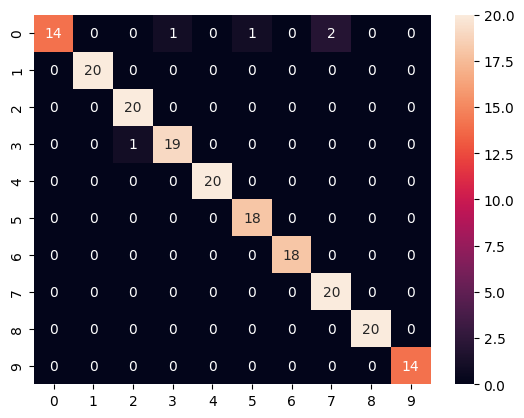

In [27]:
sns.heatmap(conf_matrix, annot=True)

## Let's test out the model

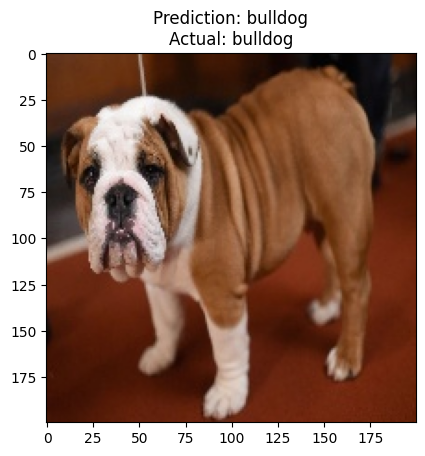

In [28]:
sample_idx = np.random.randint(0, len(test_labels))
sample_img = test_data[sample_idx][0]
# actual = test_data.breeds_dict[test_data.y[sample_idx]]
actual = test_data.breeds_dict[test_labels[sample_idx]]
prediction = test_data.breeds_dict[preds[sample_idx]]
plt.title(f'Prediction: {prediction}\nActual: {actual}')
plt.imshow(sample_img.permute(1, 2, 0))
plt.show()

## Let's look at the incorrectly predicted images

In [29]:
incorrect_preds = preds != test_labels
incorrect_preds_indices = np.where(incorrect_preds)[0]

In [30]:
incorrect_preds_indices

array([ 24,  30,  89,  94, 158])

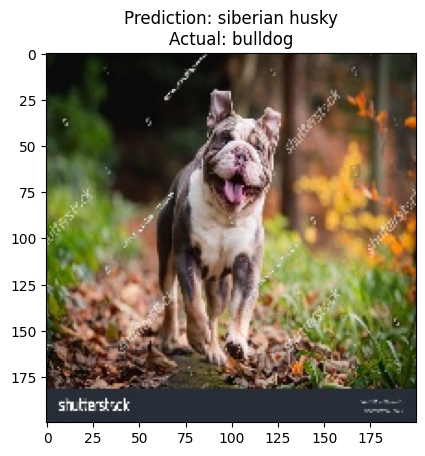

In [35]:
idx = np.random.choice(incorrect_preds_indices)
incorrectly_predicted_img = test_data[idx][0]
actual = test_data.breeds_dict[test_labels[idx]]
prediction = test_data.breeds_dict[preds[idx]]
plt.title(f'Prediction: {prediction}\nActual: {actual}')
plt.imshow(incorrectly_predicted_img.permute(1, 2, 0))
plt.show()

## Let's save the two models (the VGG16 feature extractor and the svm model)

In [38]:
torch.save(feature_extractor, 'feature_extractor.pth')
print(f'Saved feature extractor model to /models/feature_extractor.pth')
print()

joblib.dump(model, 'model.pkl')
print(f'Saved the final ML model to /models/model.pkl')

Saved feature extractor model to /models/feature_extractor.pth

Saved the final ML model to /models/model.pkl


## Key takeaways about the predictive model

- The model is performing well on the training set
- The model is performing pretty well on the test set
- The model is finding it a bit difficult to distinguish between the two classes Labrador Retriever and Golden Retriever
- The model is occasionally misclassifying the Bulldogs